In [8]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

In [32]:
all_cn_data_fp = "/Users/massoudmaher/data/sc_1935_1936_1937_cn_data_qc.csv"
all_cn_data = pd.read_csv(all_cn_data_fp)
all_cn_data = all_cn_data.iloc[:,1:]
###
all_cn_data = all_cn_data[all_cn_data["chr"]=="X"]

In [33]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 12
prob_cn_change = 0.7
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [34]:
subsample = utils.get_cn_data_submixture(all_cn_data, total_ncells, hmmcopy_tickets, sample_ids, proportions=proportions)

mixed_cn_data = subsample["mixed_cn_data"]
mixed_cn_data["origin_id_int"] = mixed_cn_data["origin_id"].factorize()[0]
cell_counts = subsample["cell_counts"]

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jira_cn_data[origin_field_name] = hmmcopy_tickets[i]


In [54]:
params = simulation.expand_grid({
    "alpha":[0.0000001, 0.00001, 0.01, 0.1],
    #"alpha":[0.00001],
    "distance":[11]
    #"distance":[7,9,11,13]
})

def apply_fn(row):
    bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
        cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=row["alpha"], prob_cn_change=prob_cn_change)
    )
    bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
    lbhc_plot_data = bhc_plot_data.copy()
    lbhc_plot_data[:,2] = np.log(lbhc_plot_data[:,2]) # Log because the highest link is way higher
    
    row["linkage"] = lbhc_plot_data
    
    clustering = sch.fcluster(lbhc_plot_data, row["distance"], criterion="distance")
    cmixed_cn_data = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)
    
    row["cn_data"] = cmixed_cn_data

    clabels = get_mixture_labels(cmixed_cn_data)
    scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
    row["homogeneity"] = scores[0]
    row["completeness"] = scores[1]
    row["v_measure"] = scores[2]
    
    return row

new_params = params.apply(apply_fn,axis=1)    

In [59]:
display(new_params)
mnew_params = pd.melt(new_params, id_vars=["alpha", "distance"], value_vars=["homogeneity","completeness","v_measure"])
mnew_params["nlog_alpha"] = -1 * np.log10(mnew_params["alpha"])
mnew_params.head()

,alpha,distance,linkage,cn_data,homogeneity,completeness,v_measure
0,1.000000e-07,11.0,"[[5.0, 20.0, 3.450943287188604, 2.0], [22.0, 3...",chr start end reads ...,0.445476,0.736133,0.555056
1,1.000000e-05,11.0,"[[5.0, 20.0, 3.1054759364012106, 2.0], [22.0, ...",chr start end reads ...,0.445476,0.736133,0.555056
2,1.000000e-02,11.0,"[[5.0, 20.0, 2.147563647055137, 2.0], [22.0, 3...",chr start end reads ...,0.445476,0.736133,0.555056
3,1.000000e-01,11.0,"[[5.0, 20.0, 1.4969459229291597, 2.0], [22.0, ...",chr start end reads ...,0.445476,0.736133,0.555056


,alpha,distance,variable,value,nlog_alpha
0,1.000000e-07,11.0,homogeneity,0.445476,7.0
1,1.000000e-05,11.0,homogeneity,0.445476,5.0
2,1.000000e-02,11.0,homogeneity,0.445476,2.0
3,1.000000e-01,11.0,homogeneity,0.445476,1.0
4,1.000000e-07,11.0,completeness,0.736133,7.0


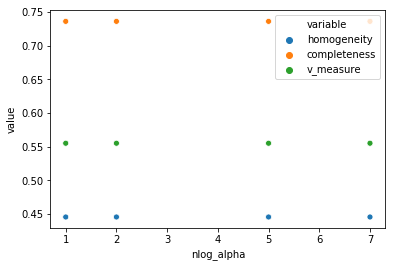

In [61]:
sns.scatterplot(data=mnew_params,x="nlog_alpha", y="value", hue="variable")

In [31]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

150.2852339744568s for BHC on 100 cells


In [116]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(lbhc_plot_data[:,2]) # Log because the highest link is way higher

naive_linkage = sch.linkage(measurement, method=naive_method, metric=naive_metric)
##
naive_linkage[:,2] = naive_linkage[:,2] + 1
lnaive_linkage = naive_linkage.copy()
lnaive_linkage[:,2] = np.log(lnaive_linkage[:,2])

In [117]:
def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

def apply_fn(row):
    if row["transform"] == "log":
        df = lnaive_linkage
    else:
        df = naive_linkage
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["naive_fcluster"] = params.apply(apply_fn, axis=1)
params["naive_num_clusters"] = params["naive_fcluster"].apply(lambda x: len(set(x)))

params.head()

,transform,criterion,threshold,bhc_fcluster,bhc_num_clusters,naive_fcluster,naive_num_clusters
0,log,inconsistent,0.025,"[1, 11, 6, 13, 3, 8, 14, 21, 44, 15, 18, 16, 7...",56,"[11, 12, 11, 12, 11, 11, 10, 4, 1, 10, 13, 10,...",19
1,log,inconsistent,0.075,"[1, 11, 6, 13, 3, 8, 14, 21, 44, 15, 18, 16, 7...",56,"[11, 12, 11, 12, 11, 11, 10, 4, 1, 10, 13, 10,...",19
2,log,inconsistent,0.125,"[1, 11, 6, 13, 3, 8, 14, 21, 44, 15, 18, 16, 7...",56,"[11, 12, 11, 12, 11, 11, 10, 4, 1, 10, 13, 10,...",19
3,log,inconsistent,0.175,"[1, 11, 6, 13, 3, 8, 14, 21, 44, 15, 18, 16, 7...",56,"[11, 12, 11, 12, 11, 11, 10, 4, 1, 10, 13, 10,...",19
4,log,inconsistent,0.225,"[1, 11, 6, 13, 3, 8, 14, 21, 44, 15, 18, 16, 7...",56,"[11, 12, 11, 12, 11, 11, 10, 4, 1, 10, 13, 10,...",19


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


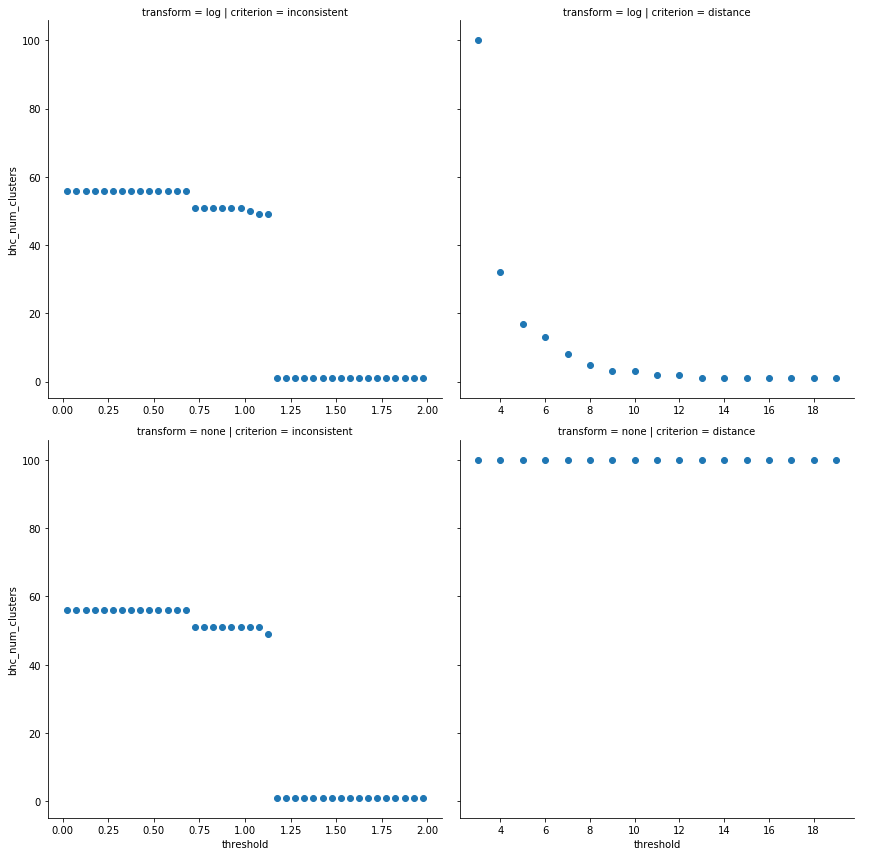

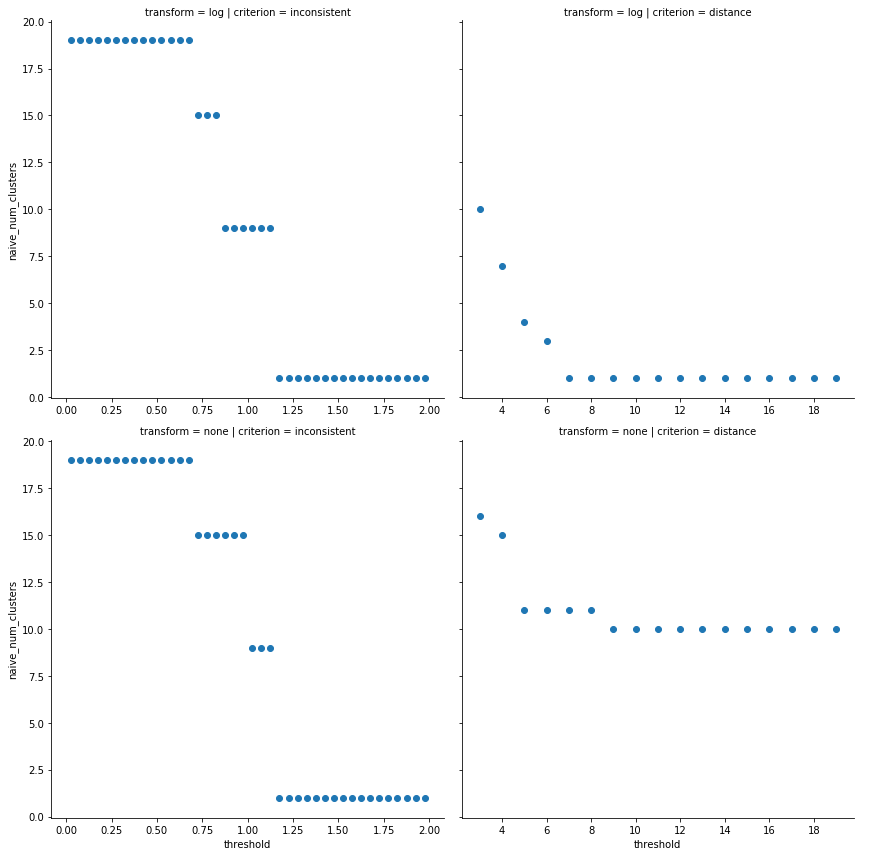

In [118]:
g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "naive_num_clusters")

## Rightmost bar represents where sample originally came frome

homogeneity: 0.4806548051130127, completeness: 0.748641295984109, v-measure: 0.5854375294929302


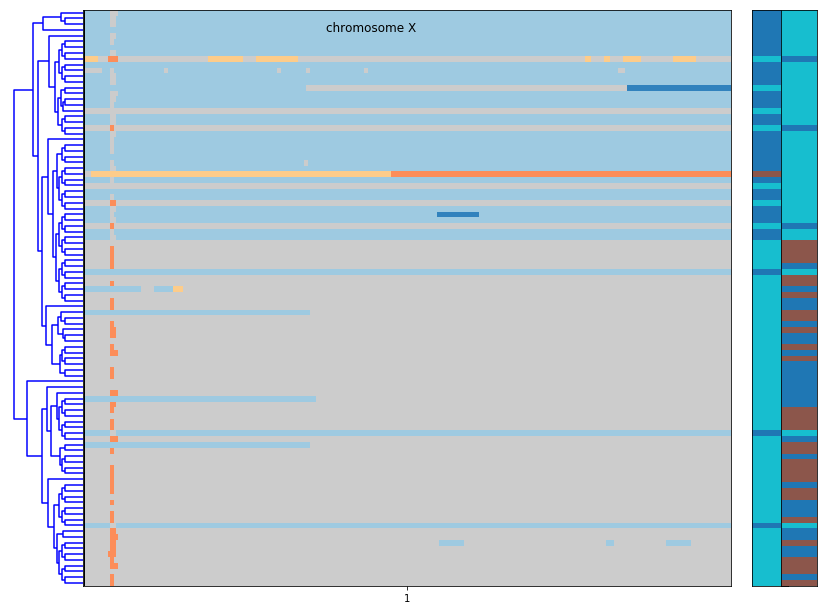

In [125]:
cmixed_cn_data = mixed_cn_data.copy()
clustering = sch.fcluster(lbhc_plot_data, 10, criterion="distance")
cmixed_cn_data = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(cmixed_cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

homogeneity: 0.41319257036380563, completeness: 0.625092217111632, v-measure: 0.4975194917971874


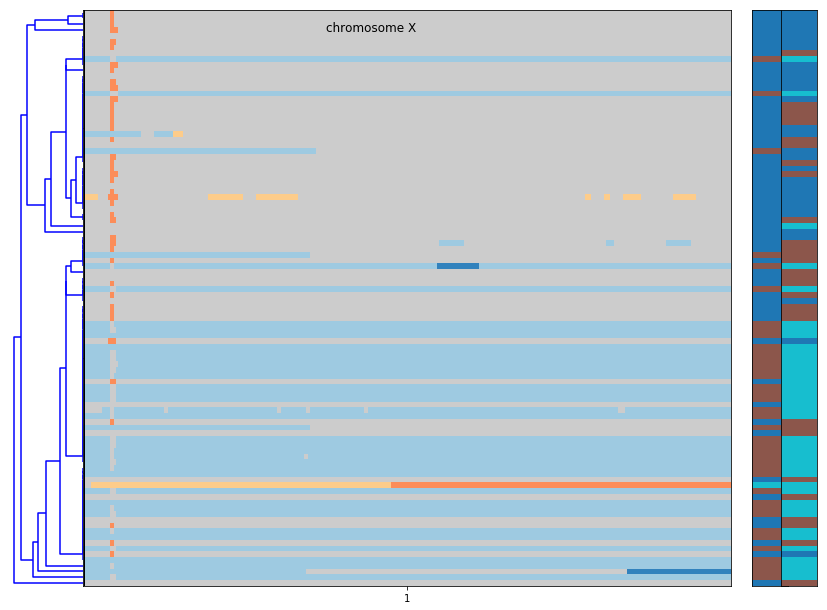

In [126]:
naive_clusters = sch.fcluster(lnaive_linkage, 6, criterion="distance")
assert len(set(naive_clusters)) > 1
nmixed_cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, mixed_cn_data, 
                                         cluster_field_name="naive_cluster_id")
fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, nmixed_cn_data, "state", cluster_field_name="naive_cluster_id",
    linkage=lnaive_linkage, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(nmixed_cn_data, obs_name="naive_cluster_id")
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["naive_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation 

homogeneity: 0.46650055905366206, completeness: 0.47766329043533423, v-measure: 0.4720159369543667


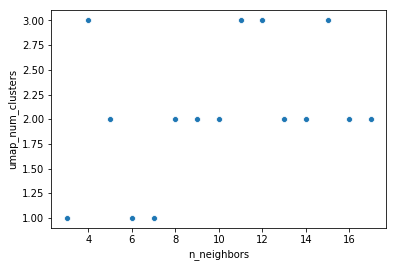

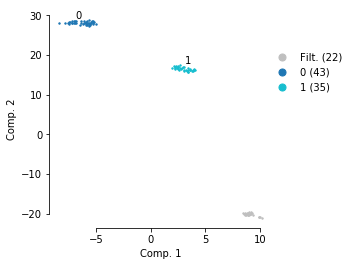

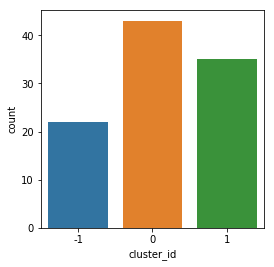

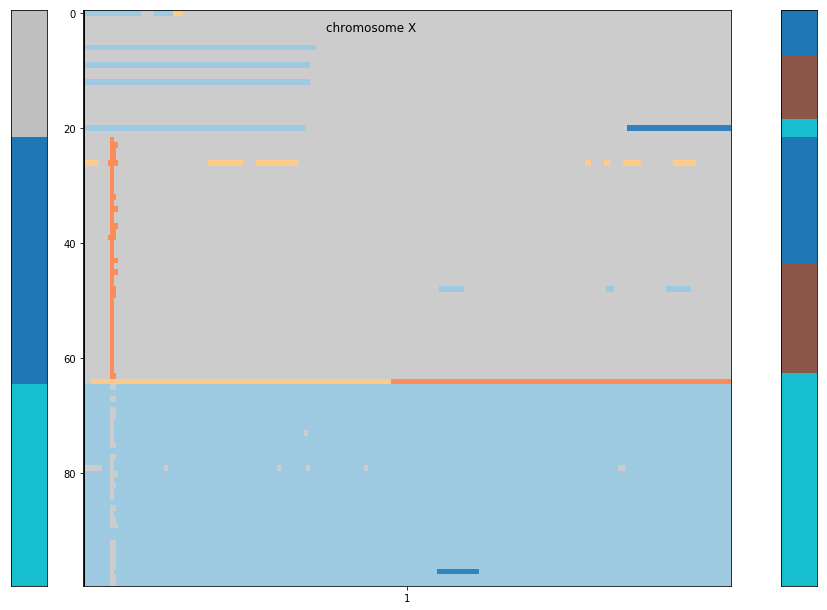

In [127]:
umap_params = utils.expand_grid({"n_neighbors": np.arange(3,18,step=1)})
def apply_fn(row):
    return cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=row["n_neighbors"])

umap_params["umap_clusters"] = umap_params.apply(apply_fn, axis=1)
umap_params["umap_num_clusters"] = umap_params["umap_clusters"].apply(lambda x: len(set(x["cluster_id"])))

sns.scatterplot(data=umap_params, x="n_neighbors", y="umap_num_clusters")

umap_df = cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=15)
umixed_cn_data = mixed_cn_data.merge(umap_df, how="inner")

fig = plt.figure(figsize=(4, 4))
cncluster.plot_umap_clusters(plt.gca(), umap_df)

fig = plt.figure(figsize=(4, 4))
sns.barplot(x='cluster_id', y='count', data=umap_df.groupby('cluster_id').size().rename('count').reset_index())


fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, umixed_cn_data, "state", cluster_field_name="cluster_id",
    linkage=None, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(umixed_cn_data, obs_name="cluster_id")
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")
#def umap_hdbscan_cluster(
#        cn,
#        n_components=2,
#        n_neighbors=15,
#        min_dist=0.1,
#):

In [52]:
new_params.to_csv("/Users/massoudmaher/data/alpha_prune_spike_in_sc1935_37.csv")